# 1. Media Company case study

From the business cases we considered for the application of linear regression, you may recall the case of a media company. This case is quite similar.



The problem statement is as follows - A digital media company (similar to Voot, Hotstar, Netflix, etc.) had launched a show. Initially, the show got a good response, but then witnessed a decline in viewership. The company wants to figure out what went wrong.

Let’s see how linear regression can be used to identify the root cause of decline in viewership.

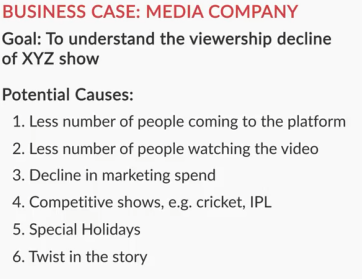

Let us now understand the data that we will use to derive our insights.

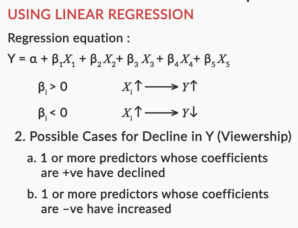

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
media_dataset_filepath = '/content/drive/MyDrive/UG-ML-AI/2.Machine_Learning-1/2.1_Linear_Regression/2. mediacompany.csv'
media_dataset_metadata_filepath = '/content/drive/MyDrive/UG-ML-AI/2.Machine_Learning-1/2.1_Linear_Regression/3. DataDictionary_mediacompany.csv'

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
# Reading the files
df_media_metadata = pd.read_csv(media_dataset_metadata_filepath)
df_media_metadata

,Variable,Explaination
0,Views_show,Number of times the show was viewed
1,Visitors,"Number of visitors who browsed the platform, b..."
2,Views_platform,Number of times a video was viewed on the plat...
3,Ad_impression,Proxy for marketing budget. Represents number ...
4,Cricket_match_india,If a cricket match was being played. 1 indicat...
5,Character_A,Describes presence of Character A. 1 indicates...


In [ ]:
df_media = pd.read_csv(media_dataset_filepath)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,Unnamed: 7
0,3/1/2017,183738,1260228,1706478,1060860448,0,0,NaN
1,3/2/2017,193763,1270561,1690727,1031846645,0,0,NaN
2,3/3/2017,210479,1248183,1726157,1010867575,0,0,NaN
3,3/4/2017,240061,1492913,1855353,1079194579,1,0,NaN
4,3/5/2017,446314,1594712,2041418,1357736987,0,0,NaN


In [ ]:
df_media = df_media.drop('Unnamed: 7',axis=1)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A
0,3/1/2017,183738,1260228,1706478,1060860448,0,0
1,3/2/2017,193763,1270561,1690727,1031846645,0,0
2,3/3/2017,210479,1248183,1726157,1010867575,0,0
3,3/4/2017,240061,1492913,1855353,1079194579,1,0
4,3/5/2017,446314,1594712,2041418,1357736987,0,0


1 indicates that character A was present in the episode, 0 indicates she/he wasn't

# 2. Exploratory Data Analysis

Let’s try and see what we can learn from the data before going deeper into it.



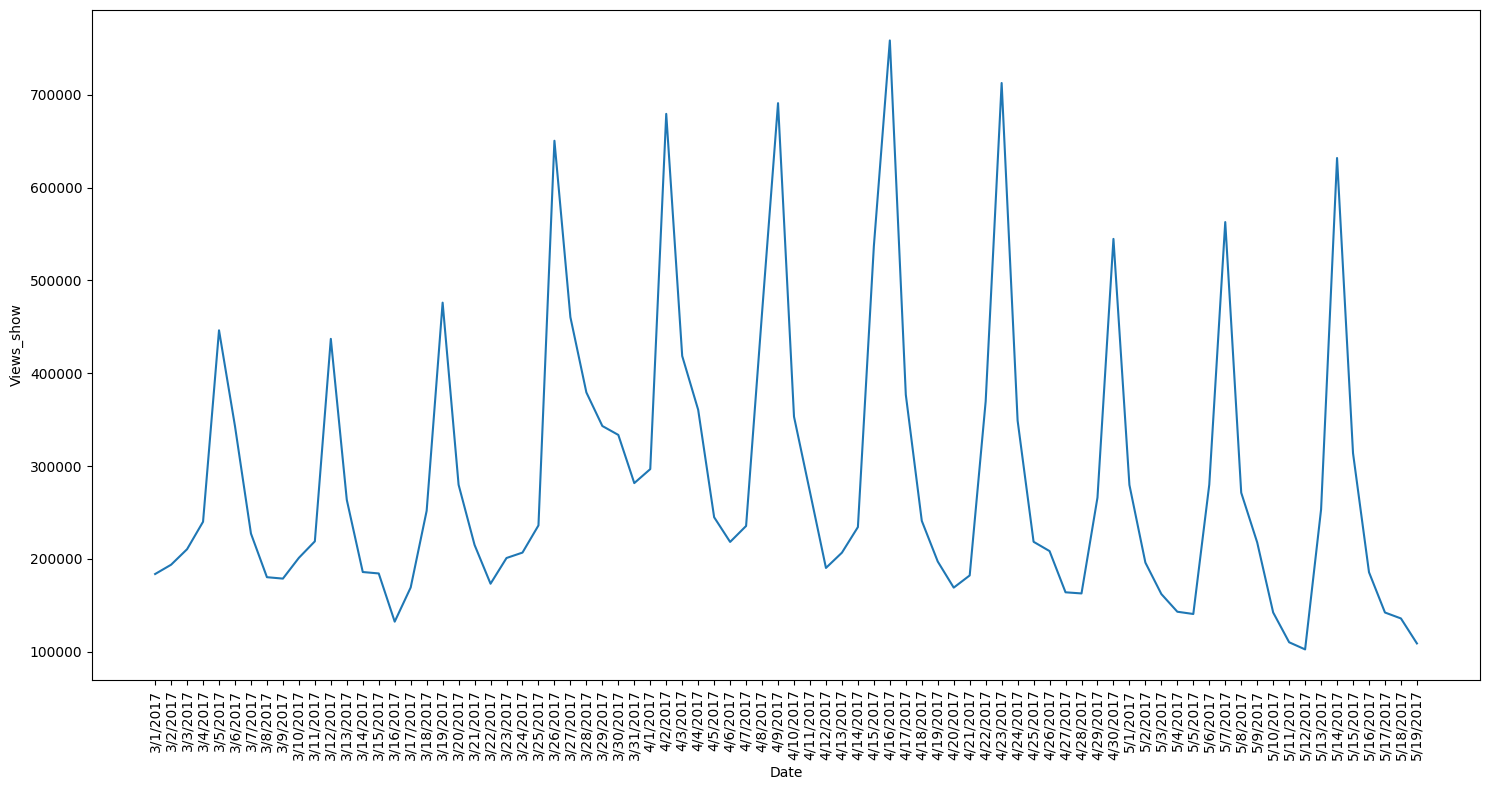

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Date',y='Views_show',data=df_media)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Observations**

1. started at 20K base, then gradually bases and the spikes shot up for first 5 weeks.
2. After 1st 5 weeks , the bases and the spikes both started to decline.
3. It follows a weekly pattern

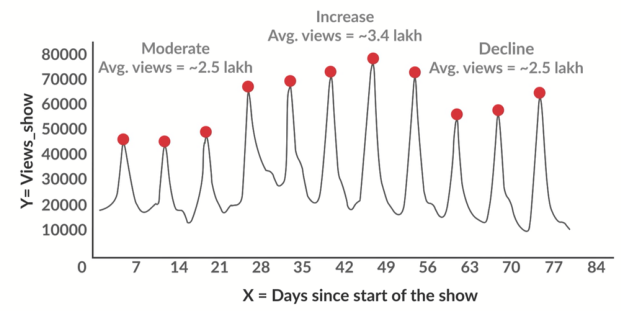

Let's plot the viewership of the show and the add impressions together

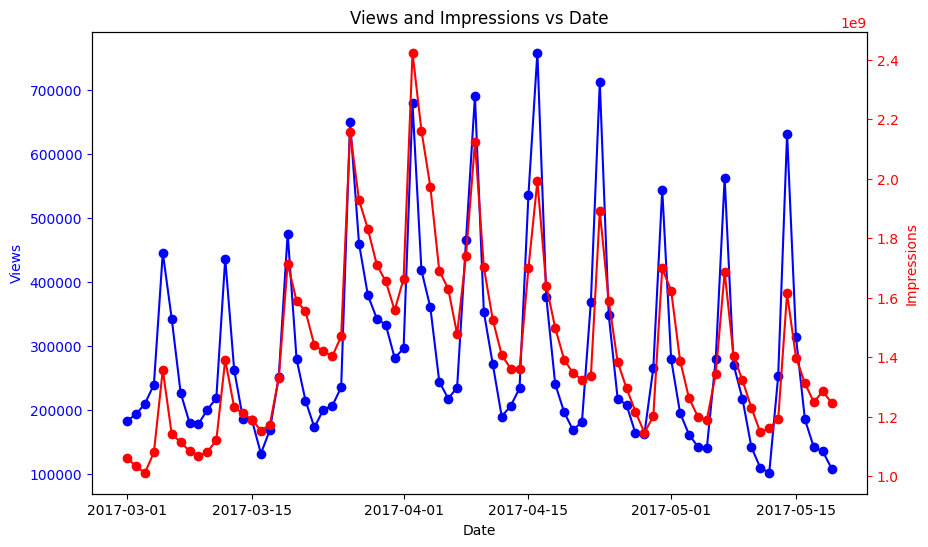

In [ ]:
# Convert 'Date' column to datetime type
df_media['Date'] = pd.to_datetime(df_media['Date'])

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting for Views on the left y-axis
ax1.plot(df_media['Date'], df_media['Views_show'], marker='o', color='b', label='Views')
ax1.set_xlabel('Date')
ax1.set_ylabel('Views', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for Impressions
ax2 = ax1.twinx()
ax2.plot(df_media['Date'], df_media['Ad_impression'], marker='o', color='r', label='Impressions')
ax2.set_ylabel('Impressions', color='r')
ax2.tick_params('y', colors='r')

# Adding labels and title
plt.title('Views and Impressions vs Date')

# Display the plot
plt.show()

**Observations**

1. Even the impressions follow weekly pattern.


You now have a good understanding of the viewership data. The next step is model building.



In [8]:
# converting to date object
df_media['Date'] = pd.to_datetime(df_media['Date'])

In [10]:
# Deriving "days since the show started"
d0 = date(2017, 2, 28)
d1 = df_media.Date
delta = pd.to_datetime(d1).dt.date - d0
df_media['day']= delta
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1 days
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2 days


In [11]:
# Cleaning days
df_media['day'] = df_media['day'].astype(str)
df_media['day'] = df_media['day'].map(lambda x: x[0:2])
df_media['day'] = df_media['day'].astype(int)
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2


In [13]:
# Derived Metrics
# Weekdays are taken such that 1 corresponds to Sunday and 7 to Saturday
# Generate the weekday variable
df_media['weekday'] = (df_media['day']+3)%7
df_media.weekday.replace(0,7, inplace=True)
df_media['weekday'] = df_media['weekday'].astype(int)
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5


# 3. Model Building - I

To arrive at a data-driven solution, you would use a linear regression model with an aim to understand what the predictors/driver KPIs for viewership are. Then, based on the model, you will be able to determine the root cause of the viewership decline.



Let us now dive into model building. Let's do the model building process through the **forward selection method**, which you learnt about in variable selection.

#### Building First model with only 2 Predictors

1. weekday , visitors (predictors)
2. views_show  (target)


In [16]:
# Choosing X and y variables
X = df_media[['weekday','Visitors']]
y = df_media['Views_show']

# create a LR object using sklearn
lm = LinearRegression()

# fit the model on X
lm.fit(X,y)

LinearRegression()

In [18]:
# building the model with statsmodels.api

# add constant
X = sm.add_constant(X)

# fit the model with OLS model
lm_1 = sm.OLS(y,X).fit()

# model summary
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     36.26
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           8.01e-12
Time:                        15:20:14   Log-Likelihood:                -1042.5
No. Observations:                  80   AIC:                             2091.
Df Residuals:                      77   BIC:                             2098.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.862e+04   1.07e+05     -0.360      0.720   -2.52e+05    1.75e+05
weekday    -3.591e+04   6591.205     -5.448      0.000    -4.9e+04   -2.28e+04
Visitors       0.2787      0.057      4.911      0.000       0.166       0.392
==============================================================================
Omnibus:                        2.684   Durbin-Watson:                   0.650
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.653
Skew:                           0.423   Prob(JB):                        0.265
Kurtosis:                       2.718   Cond. No.                     1.46e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Both the coefficients of weekday and visitors seems to be significant
2. Both these variables can explain variability of Views_show upto 48.5%
3. weekday coefficient is -ve , that indicates that there is a decline trend over the weekday, so it could be one of the factors leading to views decline.

#### 2. Building the model-2 with Weekend , Visitors as predictors

1. Predictors --> Weekend , Visitors
2. Target --> Views_show

Let's understand how the model performs when we consider weekend instead of weekday

Create a weekend variable

In [20]:
# create Weekend variable, with value 1 at weekends(sat,sun) and 0 at weekdays
def cond(i):
    if i % 7 == 5: return 1
    elif i % 7 == 4: return 1
    else :return 0
    return i

df_media['weekend']=[cond(i) for i in df_media['day']]
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0


In [21]:
# choose X and y
X = df_media[['weekend','Visitors']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model
lm_2 = sm.OLS(y,X).fit()

# model summary
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     38.55
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           2.51e-12
Time:                        15:31:04   Log-Likelihood:                -1041.3
No. Observations:                  80   AIC:                             2089.
Df Residuals:                      77   BIC:                             2096.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.833e+04   1.01e+05     -0.875      0.384   -2.89e+05    1.13e+05
weekend     1.807e+05   3.15e+04      5.740      0.000    1.18e+05    2.43e+05
Visitors       0.1934      0.061      3.160      0.002       0.071       0.315
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.367
Skew:                           0.270   Prob(JB):                        0.505
Kurtosis:                       2.656   Cond. No.                     1.41e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**observations**

1. weekend shows the positive correlation with views_show and hence the coeff is positive
2. adding weekend parameters increased the R^2 value to 50%
3. Both the coefficients seems to have significant p-value

#### 3. Building model-3 with variables (weekend,visitors,character A)

1. predictors --> weekend , visitors , character-A
2. target --> views_show

In [22]:
# choose X and y
X = df_media[['weekend','Visitors','Character_A']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model with statsmodels
lm_3 = sm.OLS(y,X).fit()

# model summary
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     35.84
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           1.53e-14
Time:                        15:37:07   Log-Likelihood:                -1033.8
No. Observations:                  80   AIC:                             2076.
Df Residuals:                      76   BIC:                             2085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.722e+04   9.31e+04     -0.507      0.613   -2.33e+05    1.38e+05
weekend      1.812e+05   2.89e+04      6.281      0.000    1.24e+05    2.39e+05
Visitors        0.1480      0.057      2.586      0.012       0.034       0.262
Character_A  9.542e+04   2.41e+04      3.963      0.000    4.75e+04    1.43e+05
==============================================================================
Omnibus:                        0.908   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.876
Skew:                          -0.009   Prob(JB):                        0.645
Kurtosis:                       2.488   Cond. No.                     1.42e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Adding character_A seems to have great impact on views_show , hence the R^2 increased by nearly 9% from 50% --> 58.6% , whenever the character_A appears the views tend to increase greatly.
2. coefficients are highly positive
3. Even the adjusted-R^2 increased greatly, indicating the importance of the variable

first began the model with variables that seem the most important at the first instance. The model was updated with the change in variables, and the addition of new variables, that help explain the outcome better.



The first question you tried to answer was whether the decline in Visitors to the platform the main reason for the decline in the show viewership. You started with a weekday variable, and then replaced it with weekend variable to help explain the spikes in the graph better. Then you added the Character A variable, which shows the impact of the character's presence in the show Viewership.

#### 4. Build the model with 4 variables - weekend , visitors , character_A , views_show_lag_1day

1. predictors --> Lag_Views , weekend, visitors , character_A
2. target --> views_show

Intuitively it appears that the number of views today must be related to the views yesterday, e.g. if you had viewers watching the show yesterday, a large proportion of them are also expected to watch the show today.

Let's create the lag variable

In [23]:
# creating a lag variable
df_media['Lag_Views'] = np.roll(df_media['Views_show'],1)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,108961
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061


In [24]:
df_media.Lag_Views.replace(108961,0, inplace=True)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,0
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061


In [25]:
# Choose X and y
X = df_media[['Lag_Views','Character_A','weekend','Visitors']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model using statsapi
lm_4 = sm.OLS(y,X).fit()

# model summary
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     53.46
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           3.16e-21
Time:                        15:53:14   Log-Likelihood:                -1015.1
No. Observations:                  80   AIC:                             2040.
Df Residuals:                      75   BIC:                             2052.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -2.98e+04   7.43e+04     -0.401      0.689   -1.78e+05    1.18e+05
Lag_Views       0.4317      0.065      6.679      0.000       0.303       0.560
Character_A  5.527e+04   2.01e+04      2.748      0.008    1.52e+04    9.53e+04
weekend      2.273e+05    2.4e+04      9.467      0.000    1.79e+05    2.75e+05
Visitors        0.0659      0.047      1.394      0.167      -0.028       0.160
==============================================================================
Omnibus:                        1.425   Durbin-Watson:                   2.626
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.821
Skew:                          -0.130   Prob(JB):                        0.663
Kurtosis:                       3.423   Cond. No.                     1.44e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Adding Lag_Views shows high correlation with the views , that is indicating our intuition of yesterday views impacts the current day views as true.
2. R^2 and Adjusted R^2 increased significantly
3. Lag_Views has significant positive coefficient

**Quick check of our observations**

 1) Is Lag_views a significant predictor of Show_views, when modelled along "Weekend", "Visitors" and "Character_A"?


CHOICES:

● **Yes**

● No


ANSWERS:

For Lag_views, p < 0.05. Thus, Lag_views is a significant predictor of the viewership of the show.


2) What is the correlation between Lag_views and Views_show?


CHOICES:

● 0.74

● 0.89

● **0.42**

● 0.2

To know the correlation let's plot the heatmap

<ipython-input-26-e37fa2e2b170>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_media.corr(),annot=True)


<Axes: >

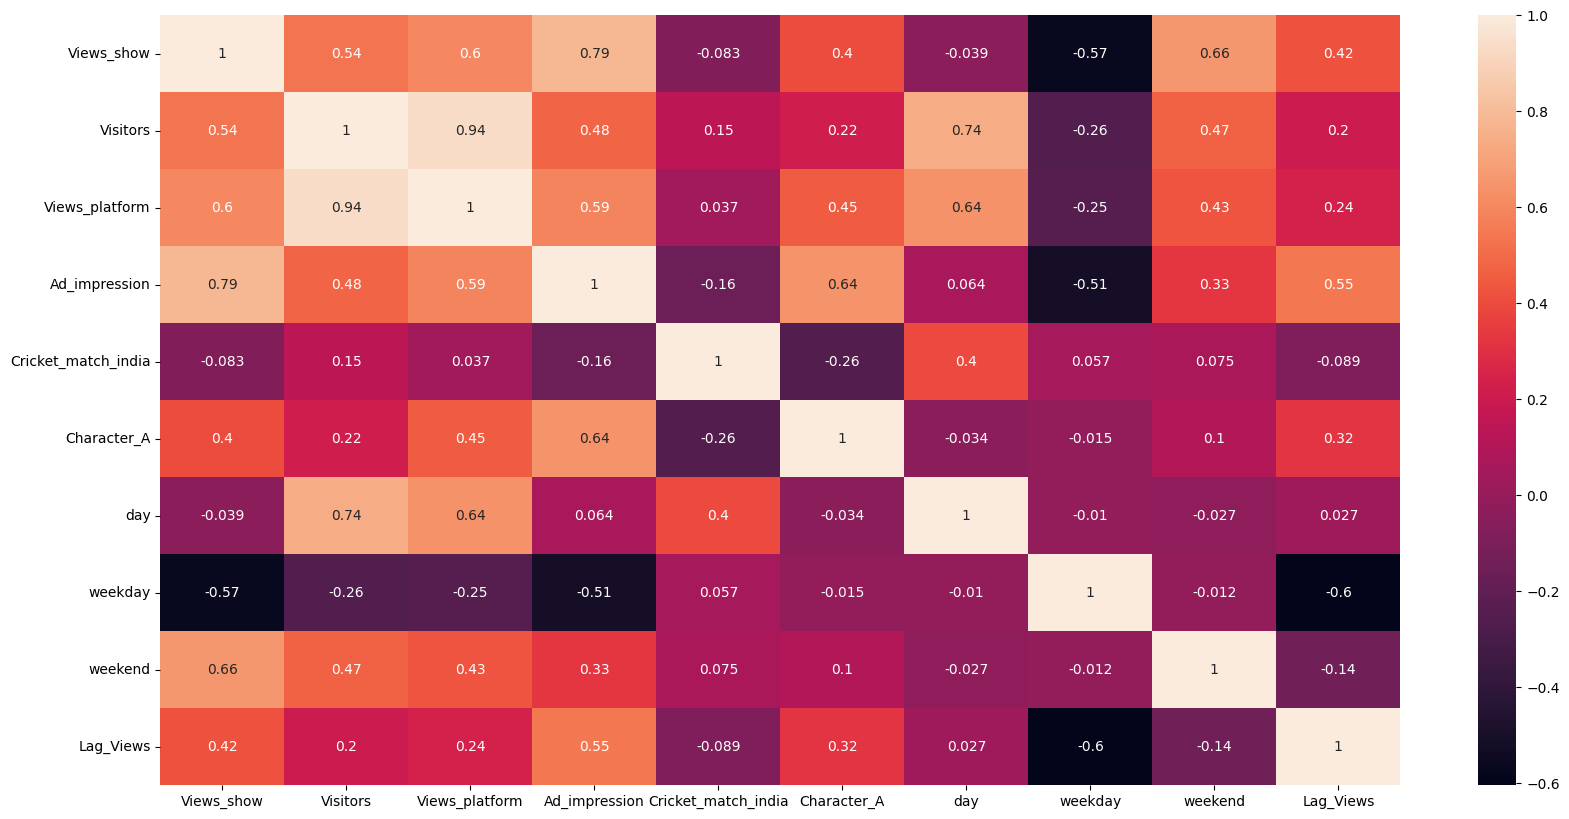

In [26]:
# heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df_media.corr(),annot=True)